In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

import cooler
import bioframe
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
import csv
bp_formatter = EngFormatter('b')

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def peaksTosummits(peakslst,summitslst):
#    print(len(peakslst),len(summitslst))
    summits_out = []
    for i in range(len(peakslst)):
        p = peakslst[i]
        s = summitslst[i].iloc[:,0:4]
        s1 = s.rename(columns={0:'chrom', 1:'start', 2:'end',3:'peak_name'}, inplace=False)
        x = bioframe.closest(df1=s1,df2=p)
        x1 = x[x['distance']==0]
        
        x2 = x1.iloc[:,0:4]
        x3 = x2.rename(columns={'chrom_1':'chrom', 'start_1':'start', 
                                'end_1':'end','peak_name_1':'peak_name'}, inplace=False)
 #       print(len(s),len(x3))
        summits_out.append(x3)
    return summits_out

def PairwiseOverlap(Peaks_lst,Summits_lst):
    P = []
    for i in range(len(Peaks_lst)):
        x = Peaks_lst[i].iloc[:,0:4]
        x1 = x.rename(columns={0:'chrom', 1:'start', 2:'end',3:'peak_name'}, inplace=False)
        P.append(x1)
    ### A vs. B ###
    AB = bioframe.closest(df1=P[0],df2=P[1])
    A_and_B = AB[AB['distance']==0]
    A_not_B = AB[AB['distance']>0]
    
    BA = bioframe.closest(df1=P[1],df2=P[0])
    B_and_A = BA[BA['distance']==0]
    B_not_A = BA[BA['distance']>0]    
    
    ### ven diagram ###
    A,B = len(P[0]),len(P[1])
    Ab = len(A_not_B)
    aB = len(B_not_A)
    AB = len(A_and_B)
    
    print('A:',A, 'B:',B, 'AB:',AB,'Ab:',Ab,'aB:',aB)
    ### format ###
    unique_df = [A_not_B, B_not_A]
    unique_df_bed = []
    for i in range(len(unique_df)):
        x = unique_df[i].iloc[:,0:4]
        x1 = x.rename(columns={'chrom_1':'chrom', 'start_1':'start', 
                               'end_1':'end','peak_name_1':'peak_name'}, inplace=False)
        unique_df_bed.append(x1)
    
    common_df = [A_and_B,B_and_A]
    common_df_bed = []
    for i in range(len(common_df)):
        x = common_df[i].iloc[:,0:4]
        x1 = x.rename(columns={'chrom_1':'chrom', 'start_1':'start', 
                               'end_1':'end','peak_name_1':'peak_name'}, inplace=False)
        common_df_bed.append(x1)
    
    ######### peaks to summit conversion #########
    unique_summits = peaksTosummits(peakslst=unique_df_bed,summitslst=Summits_lst)
    common_summits = peaksTosummits(peakslst=common_df_bed,summitslst=Summits_lst)
    
    return unique_df_bed, unique_summits, common_df_bed, common_summits

In [3]:
jets = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed6')
jets['chrom'] = 'chr' + jets['chrom'] ### jets


In [4]:
# smc3
smc3_noaux_s = bioframe.read_table('/scratch/cgsb/ercan/Jun_cohesin/cohesin_revision/haoyu_chip/SMC3_Q4469_HW04_1h_noaux_L2L3_ext783_HW55_input_HW59_avg_HW51_HW55_chip_summits.bed',schema='bed12')
smc3_aux_s = bioframe.read_table('/scratch/cgsb/ercan/Haoyu/08282024ChIP/MACSoutput/SMC3_Q4469_HW04_1h_aux_L2L3_ext784_HW65_1_avg_HW61_1_HW65_1_chip_summits.bed',schema='bed12')

smc3_noaux_p = bioframe.read_table('/scratch/cgsb/ercan/Jun_cohesin/cohesin_revision/haoyu_chip/SMC3_Q4469_HW04_1h_noaux_L2L3_ext783_HW55_input_HW59_avg_HW51_HW55_chip_peaks.bed',schema='bed12')
smc3_aux_p = bioframe.read_table('/scratch/cgsb/ercan/Haoyu/08282024ChIP/MACSoutput/SMC3_Q4469_HW04_1h_aux_L2L3_ext784_HW65_1_avg_HW61_1_HW65_1_chip_peaks.bed',schema='bed12')


# nipbl
nipbl_noaux_s = bioframe.read_table('/scratch/cgsb/ercan/Jun_cohesin/cohesin_revision/haoyu_chip/PQN85_Q4481_HW04_1h_noaux_L2L3_ext783_HW56_input_HW59_avg_HW52_HW56_chip_summits.bed',schema='bed12')
nipbl_aux_s = bioframe.read_table('/scratch/kimj50/NIPBL_re/MACSoutput/PQN85_Q4481_HW04_1h_aux_avg_HW62_1_HW66_1_chip_summits.bed',schema='bed12')

nipbl_noaux_p = bioframe.read_table('/scratch/cgsb/ercan/Jun_cohesin/cohesin_revision/haoyu_chip/PQN85_Q4481_HW04_1h_noaux_L2L3_ext783_HW56_input_HW59_avg_HW52_HW56_chip_peaks.bed',schema='bed12')
nipbl_aux_p = bioframe.read_table('/scratch/kimj50/NIPBL_re/MACSoutput/PQN85_Q4481_HW04_1h_aux_avg_HW62_1_HW66_1_chip_peaks.bed',schema='bed12')

 
# h4k20
h4_noaux_s = bioframe.read_table('/scratch/cgsb/ercan/Haoyu/08282024ChIP/MACSoutput/H4K20me1_ab9051_HW04_1h_noaux_L2L3_ext783_HW77_avg_HW76_HW77_chip_summits.bed',schema='bed12')
h4_aux_s = bioframe.read_table('/scratch/cgsb/ercan/Haoyu/08282024ChIP/MACSoutput/H4K20me1_ab9051_HW04_1h_aux_L2L3_ext785_HW79_avg_HW78_HW79_chip_summits.bed',schema='bed12')
h4_noaux_p = bioframe.read_table('/scratch/cgsb/ercan/Haoyu/08282024ChIP/MACSoutput/H4K20me1_ab9051_HW04_1h_noaux_L2L3_ext783_HW77_avg_HW76_HW77_chip_peaks.bed',schema='bed12')
h4_aux_p = bioframe.read_table('/scratch/cgsb/ercan/Haoyu/08282024ChIP/MACSoutput/H4K20me1_ab9051_HW04_1h_aux_L2L3_ext785_HW79_avg_HW78_HW79_chip_peaks.bed',schema='bed12')



In [5]:
noaux = [nipbl_noaux_s,smc3_noaux_s,h4_noaux_s]
aux = [nipbl_aux_s,smc3_aux_s, h4_aux_s]

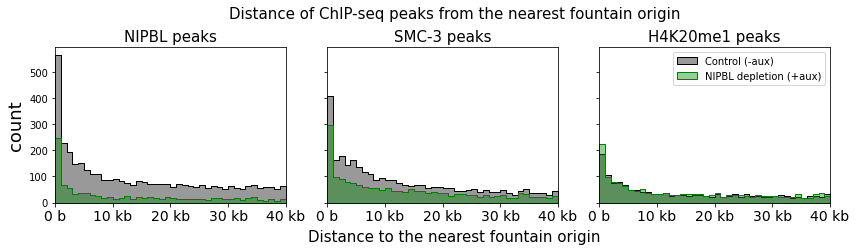

In [6]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(12, 3),
    nrows=1,
    ncols=3,
    sharey=True,
    sharex=True
)


#Label_1 = 'Control'
#Label_2 = 'SMC-3 depletion'
Labels = ['Control (-aux)','NIPBL depletion (+aux)']
Titles = ['NIPBL peaks','SMC-3 peaks','H4K20me1 peaks']
Maxd = 40_000

for i in range(3):
    t = bioframe.closest(noaux[i],jets)
    t2 = t[t['distance']<=Maxd]['distance']
    a = sns.histplot(ax=axs[i],data = t2, kde = False, label=Labels[0],
                 stat = "count",color='black',alpha=0.4,binwidth=1000,element='step')
    t = bioframe.closest(aux[i],jets)
    t2 = t[t['distance']<=Maxd]['distance']
    a = sns.histplot(ax=axs[i],data = t2, kde = False, label=Labels[1],
                 stat = "count",color='green',alpha=0.4,binwidth=1000,element='step')
    
    a.set_ylabel('count' ,rotation=90,fontsize=18,labelpad=4)
    a.set_title(Titles[i],fontsize=15)
    if i == 2:
        a.legend(prop={'size': 10})
    
    
    a.set_xlabel('')
    format_ticks(a,x=True,y=False,rotate=False)
    a.set_xlim(0,40_000)
    a.xaxis.set_tick_params(labelsize=14)


    
f.text(0.53,1,'Distance of ChIP-seq peaks from the nearest fountain origin',fontsize=15, ha='center')

f.text(0.53, -0.03, 'Distance to the nearest fountain origin', 
       ha='center',fontsize=15)

plt.tight_layout()    

In [7]:
####################################### peaks overlap #########################################

smc3_P = [smc3_noaux_p,smc3_aux_p]
smc3_S = [smc3_noaux_s,smc3_aux_s]

nipbl_P = [nipbl_noaux_p,nipbl_aux_p]
nipbl_S = [nipbl_noaux_s,nipbl_aux_s]

h4_P = [h4_noaux_p,h4_aux_p]
h4_S = [h4_noaux_s,h4_aux_s]


nipbl_unique = PairwiseOverlap(nipbl_P,nipbl_S)
smc3_unique = PairwiseOverlap(smc3_P,smc3_S)
h4_unique = PairwiseOverlap(h4_P,h4_S)


A: 11321 B: 2678 AB: 2376 Ab: 8943 aB: 173
A: 8347 B: 4810 AB: 4230 Ab: 4116 aB: 207
A: 5499 B: 5646 AB: 4651 Ab: 848 aB: 1169


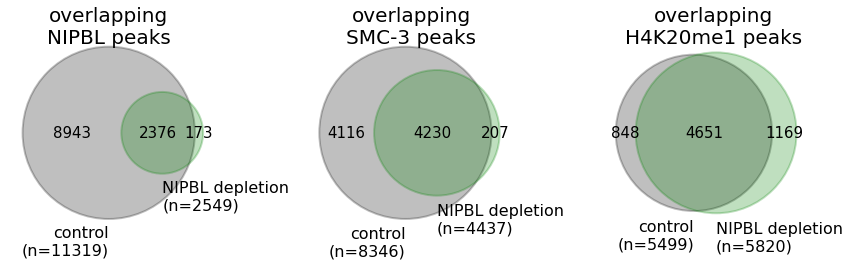

In [8]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(12, 4),
    nrows=1,
    ncols=3,
    sharey='row'
)

# (Ab,aB,AB)
subsets_nipbl = (8943 ,173,2376)
subsets_smc3 = (4116,207,4230)
subsets_h4 = (848, 1169,4651)

dat = [subsets_nipbl,subsets_smc3,subsets_h4]

for i in range(len(dat)):
    c = venn2(ax=axs[i], subsets = dat[i],
          set_labels = ('control\n(n='+str(dat[i][2]+dat[i][0])+')',
                        'NIPBL depletion\n(n='+str(dat[i][2]+dat[i][1])+')'),alpha=0)
    circles = venn2_circles(ax=axs[i],subsets = dat[i])
    for circle, color in zip(circles, ['black', 'green']):
        circle.set_lw(2.0)
#        circle.set_ls('dotted')
        circle.set_alpha(0.25)
        circle.set_color(color)
    for text in c.set_labels:
        text.set_fontsize(16)
    for text in c.subset_labels:
        text.set_fontsize(15)
f.text(0.13, 0.83, 'overlapping\nNIPBL peaks', ha='center',fontsize=20)
f.text(0.48, 0.83, 'overlapping\nSMC-3 peaks', ha='center',fontsize=20)
f.text(0.83, 0.83, 'overlapping\nH4K20me1 peaks', ha='center',fontsize=20)

plt.tight_layout()